# Employee Performance Data Modelling and Prediction

## About
We try to predict employee performance scores based 300+ employee demographic characteristics. The dataset in question was acquired as part of a homework assignment and comprises of 20,000 employees and 379 employee characteristics, 1 target variable (employee performance score).

This note book details the loading, preprocessing, sampling, feature selection, modeling and write up of the pipeline.

Setting up the notebook settings

In [1]:
!--NotebookApp.iopub_data_rate_limit=1e11

/bin/bash: --: invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option


In [0]:
import warnings
warnings.filterwarnings('ignore') 

# Project Flow Overview

1. Load Data
2. Cursory Description of Data
3. EDA
4. Feature Selection/ Extraction
5. Modelling
6. Prediction
7. Optimization
8. Modelling
9. End Point
10. Conclusion and Discussion

# 1. Load Data

In [3]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# get colmumn names for main dataset with key from other dataset
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.options.display.max_seq_items = 2000
import numpy as np

col_names = pd.read_csv("/content/drive/My Drive/sharpestminds_dataset/CodeBook-SELECT.csv")
col_names = col_names.loc[:, "VarName"].values

In [5]:
# load in the actual dataset
df = pd.read_csv("/content/drive/My Drive/sharpestminds_dataset/hw5-trainingset-cl3770.csv", header="infer")
df.head()

,cntryid,cntryid_e,age_r,gender_r,computerexperience,nativespeaker,edlevel3,monthlyincpr,yearlyincpr,lng_home,cnt_h,cnt_brth,reg_tl2,lng_bq,lng_ci,yrsqual,yrsqual_t,yrsget,vet,ctryqual,birthrgn,nativelang,ctryrgn,imyrs,imyrs_c,imyrcat,ageg5lfs,ageg10lfs,ageg10lfs_t,edcat8,edcat7,edcat6,leaver1624,leavedu,fe12,aetpop,faet12,faet12jr,faet12njr,nfe12,...,v253,v132,v284,v267,v260,v26,v171,v14,v7,v240,v186,v162,v149,v228,v28,v237,v280,v175,v288,v15,v208,v43,v27,v114,v191,v170,v65,v57,v177,v69,v85,v50,v89,v127,v239,v224,v71,v105,row,uni
0,Canada,Canada (English),NaN,Female,Yes,Yes,Medium,50 to less than 75,50 to less than 75,999,NaN,NaN,99999,eng,eng,12.0,12.0,14.0,False,NaN,NaN,Test language same as native language,North America and Western Europe,NaN,NaN,Non-immigrants,Aged 25-29,25-34,25-34,NaN,"Upper secondary (ISCED 3A-B, C long)","Upper secondary (ISCED 3A-B, C long)",NaN,NaN,Participated in FE,AET population,Participated in formal AET,Participated in formal AET for JR reasons,Did not participate in FE for NJR reasons,Did not participate in NFE,...,Never,Every day,At least once a week,Never,At least once a week but not every day,At least once a week,At least once a week but not every day,At least once a week but not every day,At least once a week but not every day,At least once a week but not every day,Never,Never,Less than once a week but at least once a month,NaN,Yes,Every day,Every day,At least once a week but not every day,Never,Less than once a week but at least once a month,Never,Never,To a high extent,To a very high extent,To a high extent,To some extent,To a high extent,To a very high extent,Never,Disagree,Neither agree nor disagree,Agree,NaN,NaN,9999.0,9996.0,9999,9999.0,80219,cl3770
1,United Kingdom,England (UK),60.0,Male,Yes,Yes,High,75 to less than 90,75 to less than 90,eng,NaN,United Kingdom of Great Britain and Northern I...,UKJ,eng,eng,15.0,15.0,NaN,NaN,NaN,North America and Western Europe,Test language same as native language,North America and Western Europe,NaN,NaN,Non-immigrants,Aged 60-65,55 plus,55 plus,Tertiary – professional degree (ISCED 5B),Tertiary – professional degree (ISCED 5B),Tertiary – professional degree (ISCED 5B),NaN,21.0,Did not participate in FE,AET population,Did not participate in formal AET,Did not participate in formal AET for JR reasons,Did not participate in FE for NJR reasons,Participated in NFE,...,At least once a week,Every day,At least once a week,At least once a week but not every day,Less than once a month,Rarely,At least once a week but not every day,Less than once a month,Every day,Every day,Less than once a week but at least once a month,Less than once a month,Less than once a week but at least once a month,NaN,Yes,Every day,Every day,At least once a week but not every day,At least once a week but not every day,At least once a week but not every day,Less than once a month,Less than once a month,To a high extent,To a high extent,To a high extent,To a high extent,To a high extent,To a very high extent,Never,Agree,Strongly agree,Agree,NaN,NaN,3118.0,9996.0,2520,9996.0,44314,cl3770
2,United Kingdom,England (UK),31.0,Male,Yes,Yes,High,75 to less than 90,75 to less than 90,eng,NaN,United Kingdom of Great Britain and Northern I...,UKI,eng,eng,16.0,16.0,NaN,NaN,NaN,North America and Western Europe,Test language same as native language,North America and Western Europe,NaN,NaN,Non-immigrants,Aged 30-34,25-34,25-34,Tertiary - bachelor/master/research degree (IS...,Tertiary - bachelor/master/research degree (IS...,Tertiary - bachelor/master/research degree (IS...,NaN,NaN,Participated in FE,AET population,Participated in formal AET,Participated in formal AET for JR reasons,Did not participate in FE for NJR reasons,Participated in NFE,...,At least once a week,Less than once a week but at least once a month,Less than once a week but at least once a month,Less than once a month,Less than once a month,Rarely,Less than once a month,At least once a week but not every day,At least once a week but

### The dataset is a 93Mb csv file

In [6]:
!du -hs "/content/drive/My Drive/sharpestminds_dataset/hw5-trainingset-cl3770.csv"

93M	/content/drive/My Drive/sharpestminds_dataset/hw5-trainingset-cl3770.csv


In [7]:
# we have a lot of data here
print("{} features, {} observations".format(df.shape[1], df.shape[0]))

# we also have a lot of non-numeric data as well
print(df.info())

print(df.describe())

380 features, 20000 observations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 380 entries, cntryid to uni
dtypes: float64(80), int64(5), object(295)
memory usage: 58.0+ MB
None
              age_r       yrsqual  ...          v105            row
count  12118.000000  17417.000000  ...  19979.000000   20000.000000
mean      39.339412     14.573549  ...   9833.138696   96825.751700
std       11.004673      2.703482  ...   1009.110938   57590.955791
min       16.000000      5.000000  ...     31.000000      98.000000
25%       31.000000     12.000000  ...   9996.000000   46369.000000
50%       38.000000     15.000000  ...   9996.000000   94729.000000
75%       48.000000     16.000000  ...   9996.000000  147668.500000
max       65.000000     22.000000  ...   9999.000000  197786.000000

[8 rows x 85 columns]


In [8]:
# country based features
country_features = ['ctryrgn', 'ctryqual', 'birthrgn', 'reg_tl2', 'cntryid_e', 'cntryid']


@@@ ctryrgn @@@
North America and Western Europe                13208
Central and Eastern Europe                       3268
East Asia and the Pacific (richer countries)     3036
Latin America and the Caribbean                   344
Name: ctryrgn, dtype: int64
Number of unique values: 5


@@@ ctryqual @@@
North America and Western Europe                5236
East Asia and the Pacific (richer countries)    3122
Central and Eastern Europe                      2078
East Asia and the Pacific (poorer countries)      16
Latin America and the Caribbean                   10
South and West Asia                                6
Sub-Saharan Africa                                 3
Arab States                                        2
Central Asia                                       1
Name: ctryqual, dtype: int64
Number of unique values: 10


@@@ birthrgn @@@
North America and Western Europe                5439
Central and Eastern Europe                      3324
East Asia and the Pacific (richer c

# 3. EDA - Missing Values

### We print out the the counts of observations with missing values in this dataset

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# There are a lot of missing values in this dataset
print(df.isnull().sum().sort_values(ascending=False)[df.isnull().sum() > 1000][:25])

v262    20000
v44     19997
v76     19993
v144    19992
v199    19991
v159    19985
v10     19981
v172    19977
v110    19956
v160    19955
v100    19955
v109    19954
v75     19938
v211    19938
v215    19936
v163    19935
v220    19927
v254    19923
v38     19910
v129    19910
v266    19907
v89     19864
v127    19828
v117    19793
v287    19792
dtype: int64


## Missing Data Proportion by Columns
We will want to drop a number of the columns have have a significant amount of its data missing. Some features have disproportionately more data missing than others and there will be no way to impute those features. In which case dropping those features might be the best course of action to clean up the dataset. Feature column values that have a proportion of their data missing equal to or greater than an arbitrary threshold will have their columns dropped. Afterwards, a row-wise operation of this procedure will be further applied to include cleaner samples in the dataset. 
________________

We will examine to see which features reach this threshold requirement to be dropped before we do any such dropping. 
____________ 

Afterwards, we will want to smarly impute the remaining missing data points as much as we can.

In [11]:
# features by % of missing data
dropthreshold = 50

pct_missing_list = list([col for col in df.columns if df[col].isnull().sum()/df.shape[0] * 100 >= dropthreshold])
pm_list = []


for col in df.columns:
    if df[col].isnull().sum()/df.shape[0] * 100 >= dropthreshold:
        pm_list.append(df[col].isnull().sum()/df.shape[0] * 100)
        
missing_data_series = pd.DataFrame(pm_list, columns=['% Missing Data'], index=pct_missing_list).sort_values(by='% Missing Data', ascending=False)

# get the data points in the dataframe that have >= 60% of their data missing
df_col_drop_gtoe_60 = df[pct_missing_list]
kept_feat_cols = list(set(df.columns) - set(pct_missing_list))
reduced_cols_gtoe_60_missing_df = df[kept_feat_cols]

print("The features with {}% or more of it's data missing will be dropped from the dataset.".format(dropthreshold))
print("The number of features of the dataset has been reduced by {}% after dropping the columns with a more than {}% of its data missing.".format(reduced_cols_gtoe_60_missing_df.shape[1]/df.shape[1] * 100, dropthreshold))
print("This is the size of the dataset before it was reduced: {}".format(df.shape))
print("The shape of the data that would be dropped with >= {}% of its data missing : {}".format(dropthreshold, df_col_drop_gtoe_60.shape))
print("This is the shape of the remaining dataset, after having dropped the data points with GTOE {}% of the data missing: {}, " \
"meaning that {} columns of the original dataframe will be dropped".format(dropthreshold, reduced_cols_gtoe_60_missing_df.shape, len(df.columns) - len(kept_feat_cols)))

# save the results to csv to look at later
# missing_data_series.to_csv('./features_greater_{}_percent_missing_data_by_cols.csv'.format(dropthreshold))

# write out the dataframe after having dropped the rows
# reduced_cols_gtoe_60_missing_df.to_csv('./reduced_cols_gtoe_{}_missing_df.csv'.format(dropthreshold))

The features with 50% or more of it's data missing will be dropped from the dataset.
The number of features of the dataset has been reduced by 63.68421052631579% after dropping the columns with a more than 50% of its data missing.
This is the size of the dataset before it was reduced: (20000, 380)
The shape of the data that would be dropped with >= 50% of its data missing : (20000, 138)
This is the shape of the remaining dataset, after having dropped the data points with GTOE 50% of the data missing: (20000, 242), meaning that 138 columns of the original dataframe will be dropped


## Missing Data Proportion By Row 
An alternative strategy would be just to drop all of the rows with missing values. This step requires a little more wor as we will have more than 0 data points that have missing values and require imputation of missing values.


Lets first drop any data ROWS with 50% or more missing values and see what we end up with.

________________


Just a refresher on how to how to conditionally select rows from a data frame:

To select rows whose column value equals a scalar, some_value, use ==:
df.loc[df['column_name'] == some_value]


To select rows whose column value is in an iterable, some_values, use isin:
df.loc[df['column_name'].isin(some_values)]

Combine multiple conditions with &:
df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]





In [12]:
# Data points with percentage of data missing and greater will be dropped from the dataset
dropthreshold = 20

# get the data points in the dataframe that have >= 30% of their data missing
df_row_gtoe_20_missing = reduced_cols_gtoe_60_missing_df.loc[(reduced_cols_gtoe_60_missing_df.isnull().sum(axis=1)/reduced_cols_gtoe_60_missing_df.shape[1]*100 >= dropthreshold)]
reduced_row_gtoe_20_missing = reduced_cols_gtoe_60_missing_df.loc[(reduced_cols_gtoe_60_missing_df.isnull().sum(axis=1)/reduced_cols_gtoe_60_missing_df.shape[1]*100 <= dropthreshold)]

print("The data points with {}% or more of it's data missing will be dropped from the dataset.".format(dropthreshold))
print("The size of the dataset has been reduced by {}% after dropping the rows with {}% of its data missing.".format(df_row_gtoe_20_missing.shape[0]/reduced_cols_gtoe_60_missing_df.shape[0] * 100, dropthreshold))
print("The size of the dataset remaining after the missing data points have been dropped {}%.".format(reduced_row_gtoe_20_missing.shape[0]/reduced_cols_gtoe_60_missing_df.shape[0] * 100))
print("This is the size of the dataset before it was reduced: {}".format(reduced_cols_gtoe_60_missing_df.shape))
print("The shape of the data that would be dropped with >= {}% of its data missing : {}".format(dropthreshold, df_row_gtoe_20_missing.shape))
print("This is the shape of the remaining dataset, after having dropped the data points with GTOE {}% of the data missing: {}".format(dropthreshold, reduced_row_gtoe_20_missing.shape))
print("As a result, {} data points have been dropped due to insufficient data".format(reduced_cols_gtoe_60_missing_df.shape[0] - reduced_row_gtoe_20_missing.shape[0]))

# give the new dataframe a better name
final_kept_df = reduced_row_gtoe_20_missing

# save the dataframe to disk after the processing
# final_kept_df.to_csv('./final_kept_df.csv')

The data points with 20% or more of it's data missing will be dropped from the dataset.
The size of the dataset has been reduced by 5.59% after dropping the rows with 20% of its data missing.
The size of the dataset remaining after the missing data points have been dropped 94.41000000000001%.
This is the size of the dataset before it was reduced: (20000, 242)
The shape of the data that would be dropped with >= 20% of its data missing : (1118, 242)
This is the shape of the remaining dataset, after having dropped the data points with GTOE 20% of the data missing: (18882, 242)
As a result, 1118 data points have been dropped due to insufficient data


## Missing Data by Data Type
We can see that there are a considerable amount of missing values for this dataset. We will have to dig in to understand which features would have missing values, and can we come up with a strategy to handle it.

In [13]:
# separate out the numeric and categorical variables to see how much of each are missing

numeric_df = final_kept_df._get_numeric_data()
categorical_df = final_kept_df.select_dtypes(exclude = [int, float])

print("Number of Numeric Features: {}".format(numeric_df.shape[1]))
print("Number of Categorical Features: {}".format(categorical_df.shape[1]))

Number of Numeric Features: 37
Number of Categorical Features: 205


## Numeric Feature Missing Values

It still appears that after dropping the data points and features with a majority of their data points missing, that about a third of the numeric features containg NaN/missing values in more than 20% of their data points.

Proportionally, numeric features contribute 15.29% of the total features in the dataset
leavedu      44.020761
v202         38.894185
age_r        38.703527
v231         38.110370
nfehrs       37.850863
v272         37.612541
v52          37.379515
v33          37.337146
v63          36.987607
yrsget       17.847686
yrsqual_t    13.372524
yrsqual      12.832327
dtype: float64
The number of numeric features with more than 20% of its values missing is: 9, which is 24.324324324324326% of all numeric features


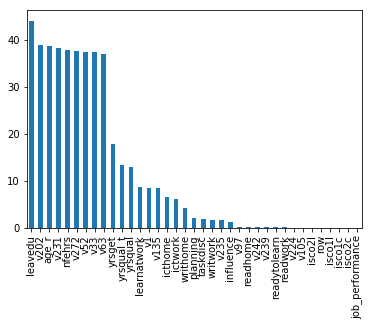

In [14]:
# take a look at the missing values from the numeric features dataframe
print("Proportionally, numeric features contribute {0:.2f}% of the total features in the dataset".format(numeric_df.shape[1]/final_kept_df.shape[1]*100))
a = pd.Series(numeric_df.isnull().sum().sort_values(ascending=False)/(numeric_df.shape[0]) * 100)
print(a[:12])
a.plot(kind='bar')

# 9 numeric features of 37 with more than 20% of it's data missing
print("The number of numeric features with more than 20% of its values missing is: {}, which is {}% of all numeric features".format(9, (9/numeric_df.shape[1]*100)))

We are going to explore correlation/collinearity between the numeric features and drop redundant features.

In [55]:
# categorical feature with numeric encoding

cat_feat_with_num_encoding = ['isic2l', 'v224', 'isco1l', 'v105', 'isco1c', 'v239', 'isco2c', 'v105']
for i in cat_feat_with_num_encoding:
    print("This categorical feature with numeric encodings has {} unique values: {}".format(i, len(numeric_df[i].unique())))

This categorical feature with numeric encodings has isic2l unique values: 37
This categorical feature with numeric encodings has v224 unique values: 62
This categorical feature with numeric encodings has isco1l unique values: 11
This categorical feature with numeric encodings has v105 unique values: 58
This categorical feature with numeric encodings has isco1c unique values: 15
This categorical feature with numeric encodings has v239 unique values: 413
This categorical feature with numeric encodings has isco2c unique values: 50
This categorical feature with numeric encodings has v105 unique values: 58


## Pre-Imputer Imputation for numeric features
Some further processing can be done before the imputation step such as (dropping,casting, merging, etc). The next few segments of code will go through the next preprocessing steps as outlined above.

In [0]:
# we drop 'age_r' as there is another categorical feature containing the same demographic information with more completeness, with the tradeoff of numeric granularity
numeric_df.drop(columns='age_r', inplace=True, axis=1)

In [0]:
# we drop 'row' because this is a pretty useless category
numeric_df.drop(columns='row', inplace=True, axis=1)

## Examination of the categorical features

Proportionally, categorical features contribute 84.71% of the total features in the dataset
ctryqual          47.251350
v291              45.689016
v137              45.122339
cnt_brth          43.745366
v3                39.725665
birthrgn          37.061752
v269              35.833069
v91               35.817180
v47               33.095011
v236              32.994386
v289              27.846626
v96               25.675246
earnhrbonusdcl    23.111958
earnhrdcl         22.863044
v255              22.068637
v212              21.787946
reg_tl2           20.040250
v62               18.011863
earnflag          17.365745
v8                17.222752
dtype: float64
The number of categorical features with more than 20% of its values missing is: 17, which is 8.292682926829269% of all categorical features


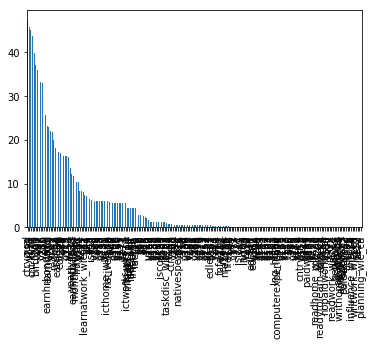

In [18]:
# take a look at the missing values for categorical features dataframe
print("Proportionally, categorical features contribute {0:.2f}% of the total features in the dataset".format(categorical_df.shape[1]/final_kept_df.shape[1]*100))
print((categorical_df.isnull().sum().sort_values(ascending=False)/(categorical_df.shape[0]) * 100 )[:20])
b = pd.Series(categorical_df.isnull().sum().sort_values(ascending=False)/(categorical_df.shape[0]) * 100 )
b.plot(kind='bar')

# 17 features with more than 20% of its values missing of 205 features
print("The number of categorical features with more than 20% of its values missing is: {}, which is {}% of all categorical features".format(17, 17/categorical_df.shape[1]*100))

## Unique categorical groupings in the categorical features 

Just to get a little perspective on how many categories there are for the dataset, we will print each of their unique values for the first several features. This will help us have an idea of how much the dataset will ballon once we onehot encode for each categorical feature value.

In [19]:
# unique values for each categorical feature. need to know how what encoding scheme we should use

num_cat_gtoe_10 = []
for column in categorical_df.columns:
    if len(categorical_df[column].unique()) >= 10:
        print(f"######### {column} ##########")
        print(categorical_df[column].unique()) # returns np.ndarray
        print("Number of unique values: {}\n".format(len(categorical_df[column].unique())))
        num_cat_gtoe_10.append(column)
print("There are {} categorical columns with more than 10 categories".format(len(num_cat_gtoe_10)))

######### isic2c ##########
['9999' '25' '35' '82' '45' '47' '85' '55' '72' '84' '64' '41' '31' '26'
 '66' '01' '73' '43' '10' '91' '81' '29' '20' '9996' '71' '86' '46' '56'
 '49' '61' '28' '22' '21' '63' '30' '52' '69' '77' '62' '51' '42' '33'
 '14' 'K' '65' '88' '24' '80' '23' '32' '08' '79' '53' 'F' '58' 'C' '92'
 '75' '27' '9995' '02' '68' '18' '87' '70' '93' '15' 'T' '17' 'G' '16'
 '74' '9998' '03' '96' '12' nan '13' 'Q' '07' '94' '11' '95' '50' '60'
 '38' '59' 'A' '78' '06' '36' '09' '19' '39' 'J' '90' '37' 'H' '9997' '05'
 'I' '97']
Number of unique values: 102

######### edcat8 ##########
[nan 'Tertiary – professional degree (ISCED 5B)'
 'Tertiary - bachelor/master/research degree (ISCED 5A/6)'
 'Tertiary – master degree (ISCED 5A)'
 'Upper secondary (ISCED 3A-B, C long)'
 'Tertiary – bachelor degree (ISCED 5A)'
 'Post-secondary, non-tertiary (ISCED 4A-B-C)'
 'Tertiary – research degree (ISCED 6)'
 'Lower secondary (ISCED 2, ISCED 3C short)'
 'Primary or less (ISCED 1 or less)'

## Impressions on missing categorical data
Proportionally, there are more missing numerical feature values than there are categorical feature values. There are some categorical feature values that use numeric values to indicate a discrete category or range. This can be gleened by particular values such as '9999' or '999' to indicate a missing value or distinct category. Some of the features that encode their values as such include:
* ~~reg_tl2~~
* ~~lng_home~~
* ~~ageg10lfs~~
* ~~ageg10lfs_t~~

These features are seemingly identical, and therefore we select one to keep and we drop the other:
* ~~ageg10lfs~~
* ~~ageg10lfs_t~~

One feature has 946 unique values which probably indicates that the values maybe numeric in nature as opposed to categorical. There are also two alphabetical letter values feature, namely : 'C' and 'G'. These values will be imputed as np.nan values before the the numeric casting of the feature column. Additionally, the numeric values in this feature are actually strings and will have to be forced cast to int or float values
* ~~v71~~

Another categorical feature uses extensive numerical coding, interleaved with few alphabetic numeric coding. The instict is to cast the alphabetical coding can be cast to np.nan before the entire feature category can be cast as a numeric column, however, after looking at the value_counts for each of categories in this feature, we can decide to leave it alone as there are a signficant numer of data points that use the alphabetical encoding:
* ~~isic2c~~

Can be cast to numeric:
* ~~isic2l~~

This feature seems to be a more granular subfeature of 'cntryrgn' and a few other of the country based features, however this feature has significantly more unique values (176 unique values). As it is a sparser representation of the other superfeatures, it can be dropped:
* ~~reg_tl2~~

There are a lot of missing values for the lng_home feature when we look at the value_counts. If questionnaire was completed in English, and the language of the exercise was done in English, then may be safe to assume that the primary language spoken at home maybe the same language. Therefore, we will apply this logic for all the missing values in the lng_home feature. These are the language categorical variables.
* ~~lng_bq~~
* ~~lng_ci~~
* ~~lng_home~~

Some features have exactly only one categorical value. These can be dropped as they do no add further information
* ~~uni -> only value is 'cl3770'~~

Instead of 'No' as the other binary value in a categorical feature, this feature has NaN instead... This value will have to be replaced with the string 'No':
* ~~v270~~

Some features have a large category space, which would balloon the dataset once onehot-encoded. There are 24 columns with more than 10 categories and they are: 
* ['isic1l', 'ageg5lfs', 'v71', 'earnmthalldcl', 'earnhrdcl', 'ctryqual', 'cntryid', 'reg_tl2', 'cnt_brth', 'isic1c', 'lng_ci', 'cntryid_e', 'v92', 'v59', 'edcat8', 'v31', 'lng_bq', 'v19', 'isic2l', 'lng_home', 'birthrgn', 'v212', 'earnhrbonusdcl', 'isic2c']

There are also many seemingly highly correlated and repeated features that can be dropped which pertain to information about which country or region an employee is from:
* 'ctryrgn', 'ctryqual', 'birthrgn', 'cntryid_e', 'cntryid'

Our best bet would be to select to keep just one of these features - preferrably a feature with a relatively low number of categories, and then drop the rest.

Therefore we will try to do our best to reduce the number of categories by possibly coming up with higher level categories to encompass these features or cast them as numeric features if the majority of their values are numerically encoded.

## Pre-Imputer Imputation for categorical features
Therefore, some of the imputation and preprocessing can be done before the encoding step of the preprocessing portion of the pipeline (dropping,casting, merging, etc). The next few segments of code will go through the next preprocessing steps as outlined above.

In [20]:
# NaN's -> 'No' for 'v270'

values = {'v270': 'No'}
categorical_df.fillna(value=values, inplace=True)
print(categorical_df['v270'].unique())

['Yes' 'No']


In [0]:
# address missing values for lng_home  and the other language features

categorical_df['lng_home'] = categorical_df['lng_bq'].where(categorical_df['lng_bq'] == categorical_df['lng_ci'])

# language features
import re
language = ['lng_bq', 'lng_ci', 'lng_home']
num_pattern = re.compile('\d\d\d')

# replace the 999 value with np.nan
for col in language:
    categorical_df[col].replace(to_replace=num_pattern, value=np.nan, inplace=True)

In [23]:
# categorical features with only one value

for column in categorical_df.columns:
    if len(categorical_df[column].unique()) <=1:
        print(column)
        print("The only unique value for {} is: {}".format(column, categorical_df[column].unique()))

# dropping column 'uni' with value only cl3770
categorical_df.drop(columns='uni', inplace=True, axis=1)

uni
The only unique value for uni is: ['cl3770']


In [0]:
# cast 'isic2l' to numeric

categorical_df['isic2l'] = categorical_df['isic2l'].fillna(-1)
categorical_df['isic2l'] = categorical_df['isic2l'].astype(int)
categorical_df['isic2l'] = categorical_df['isic2l'].astype(str)
categorical_df['isic2l'] = categorical_df['isic2l'].replace('-1', np.nan)
numeric_df['isic2l'] = categorical_df['isic2l'].values.astype(np.float64)
categorical_df.drop(columns='isic2l', axis=1, inplace=True)

In [0]:
# use regex to replace the letter values with np.nan values for feature v71
import re
pattern = re.compile("[a-zA-Z]")

categorical_df['v71'].replace(to_replace=pattern, value=np.nan, inplace=True)

# then we cast the stringed numeric values in this column to int or float
numeric_df['v71'] = categorical_df['v71'].astype(np.float64)
categorical_df.drop(columns='v71', inplace=True, axis=1)

In [0]:
# addressing the missing values of feature reg_tl2

categorical_df.drop(columns='reg_tl2', inplace=True, axis=1)

In [0]:
# from here, we select only one of these to keep and we will drop the rest

country_features = ['ctryrgn', 'ctryqual', 'birthrgn', 'cntryid_e', 'cntryid']
# categorical_df[country_features].head()

# we decide to only keep the ctryrgn and drop the rest for now, however, cntryid is another candidate to keep if we wanted more granularity with respect to country information
categorical_df.drop(columns=['ctryqual', 'birthrgn', 'cntryid_e', 'cntryid'], inplace=True, axis=1)

In [0]:
# we drop 'ageg10lfs_t' because it contains identical values to 'ageg10lfs'

categorical_df.drop(columns='ageg10lfs_t', inplace=True, axis=1)

# Encoding the Categorical Variables

We pick an encoding scheme to create dummy encoded categorical variables from our large array of categorical variables

In [0]:
# Here, we choose to choose a simple one-hot encoding scheme for our features
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(np.array(drop_null_missing_df))
encoded_df = enc.transform(drop_null_missing_df)
print(encoded_df(5))

In [0]:
# frequency numeric distribution of features 
feature_labels = [i for i in drop_null_missing_df.columns if i != "job_performance"]

for i in feature_labels[:5]:
    print("###### {} ######\n".format(i))
    print(drop_null_missing_df[i].value_counts())
    print("\n")

## Imputation for Missing Values
We want to then use an informed approach to imputation of missing data values. One method could be the use of KNN imputation or random forest and proximity matrix to imputing the missing values for our dataset with some similarity metric.

In [0]:
!pip install missingpy

In [0]:
# missing value imputation with Random Forest
# from missingpy import MissForest

In [0]:
# missing value imputation with KNN
from missingpy import KNNImputer

knn = KNNImputer(missing_values="NaN", n_neighbors=3, weights="uniform",
                 metric="masked_euclidean", row_max_missing=0.5,
                 col_max_missing=0.8, copy=True)

knn_missing_imputation = knn.fit_transform(final_kept_df)

print(type(knn_missing_imputation))

## Scaling and Normalization

This is a step we may or may not need to undertake based on the regressor that we choose to model with.

## Feature Selection: Forward Selection

We enter our feature selection step of the pipeline and we use an out of the box forward feature selection method from ML XTend to pick the features that result in the best predictive ability of our models. There are a number of different feature selection techniques that we could use (and we may explore that in the future), but for now, using a simple forward selection process is what we are going to stick with.

# Dev Branch 1 - Data Visualization for EDA

In [0]:
# Here, we plot the several categorical variables of interest against the job performance metric to visualize the distribution of job performance among the categories
# Make the plots a little bigger
sns.set(rc={'figure.figsize':(11.7,8.27)})

feature_labels = [i for i in drop_null_missing_df.columns if i != "job_performance"]

# create a FacetGrib object, on which to map your dataframe data onto
g = sns.FacetGrid(drop_null_missing_df, col="cntryid")

# Using the FacetGrid.map() function, we will be able to visualize our data. 
# Provide the map() function with a mapping function and the name of the numeric class variable in your dataframe to plot against
# each of your categorical variables
g.map(plt.hist, "job_performance", alpha=0.7)
g.add_legend()

In [0]:
# Distribution plots per categorical variable. Using A facetGrid object with the sns.distplot mapping
# function works a little differently so you will have to specify a things like row_order
categories_list = drop_null_missing_df.cntryid.value_counts().index

g = sns.FacetGrid(drop_null_missing_df, row="cntryid", row_order=categories_list,
                  height=2.0, aspect=3,)
g.map(sns.distplot, "job_performance", hist=True, rug=True);

In [0]:
# groupby country id
grouped = drop_null_missing_df.groupby("cntryid").groups
print(grouped)

In [0]:
# Plot the facetgrid for every feature against the job_performance metric
for feature in feature_labels:
    cat_list = drop_null_missing_df[feature].value_counts().index
    g = sns.FacetGrid(drop_null_missing_df, row=feature, row_order=cat_list,
                      height=1.7, aspect=4)
    g.map(sns.distplot, "job_performance", hist=True, rug=True);

# Dev Branch 1 - Handling Missing Values - Imputation Step

When we pick an imputation strategy for the our data, we have to consider our data is numeric or non-numeric. We also have to consider whether the variable is nominally categorical or ordinally categorical to determine what type of transformative encoding scheme we can apply to those features.

We also have to consider that the implications that one-hot encoding would have on our tabular dataset when we already have so many features.

## Imputation with a Strategy - EDA

Before we even start imputng, we would want to visually understand the distribution and nature of our missing data.  For example, if the data has seasonality, it would make little sense to impute with a mean value, however - if the data are constant, it may a good idea to impute the missing data value with the mean or median value.

In [0]:
# Plot the missing data features

missing_val_features = [feature for feature in df if df[feature].isnull().sum() != 0]

print("There are {} features with missing values".format(len(missing_val_features)))

for i in missing_val_features:
    print("### {} ###".format(i))
    print(df[i].value_counts())
    print("\n")

In [0]:
# each element in df.dtypes is the datatype of that feature
print(df[missing_val_features].dtypes[:10]) # i is the string of datatypes

In [0]:
# have a look at the distribution of the missing values in the features that were dropped containing
# missing values

# for feature in missing_val_features:
#     if df[feature].dtype == "object":
#         fig = plt.figure(1, figsize=(8, 14), frameon=False, dpi=100)
#         g = sns.FacetGrid(df, col=feature)
#         g.map(plt.hist, "job_performance", alpha=0.7)

## Univariate Crosstab Analysis

From what we can see, a portion of our data are categorical variables and it will be important to visually explore and visualize using cross tabulation, which is available from the pandas API.

### Cross Tab Frequency Plots of Features that were dropped due to missing values

In [0]:
# # create a cross tabulation for each categorical feature and then plot it
# # These are frequency plots of each of the values that are categorical
# # these plots include the features that were dro

# for feature in missing_val_features:
#     if df[feature].dtype == "object":
#         tabulation = pd.crosstab(index=df[feature], columns="count")
#         tabulation.plot.bar(color="green")

### Cross tab frequency plots of categorical features that did not contain any missing values

In [0]:
# for feature in feature_labels:
#     if drop_null_missing_df[feature].dtype == "object":
#         tabulation = pd.crosstab(index=drop_null_missing_df[feature], columns="count")
#         tabulation.plot.bar(color="purple")

## Bivarate Analysis using Box Plots

In [0]:
# sns.set(style="whitegrid")

# for feature in feature_labels:
#     if drop_null_missing_df[feature].dtype == "object":
#         g = sns.catplot(x=feature, 
#                     y="job_performance", 
#                     data=drop_null_missing_df,
#                     palette="Set2",
#                    kind="box")
#         g.set_xticklabels(rotation=90)

# Dev Branch 1 - Pre-Processing: Encoding Categorical Variables

For simplicity sake, we go with a one hot encoding scheme for our variables, knowing full well that this will lead to a very sparse datset. We will try and not think too hard about this at this time.

In [0]:
features_df = drop_null_missing_df.loc[:, drop_null_missing_df.columns != 'job_performance'] # print(pd.get_dummies(data))

# Separate out the features from the class
dummy_features = pd.get_dummies(drop_null_missing_df.loc[:, drop_null_missing_df.columns != 'job_performance'])
X = dummy_features.values
y = drop_null_missing_df.loc[:, "job_performance"].values

dummy_features = pd.get_dummies(drop_null_missing_df.loc[:, drop_null_missing_df.columns != 'job_performance'])
dummy_features["job_performance"] = y

print("Shape of features dataframe before dummification: {}".format(features_df.shape))
print("Shape of features dataframe after dummification: {}".format(dummy_features.shape))
print("The dataframe has increase {0:.1f}x in feature size after dummification".format(dummy_features.shape[1]/features_df.shape[1]))

In [0]:
# we also need to reset the index
dummy_features = dummy_features.reset_index()
dummy_features = dummy_features.iloc[:, 2:]

Indeed, we are working with a much more sparse dataset after we have assigned dummy variables to the categorical features

In [0]:
# Due to the sheer volume of encodings for these listed columns, we will keep these as typed
# as integers as opposed to the nominal nature of the their encoding

iscolc_columns = ["isco1c", "isco2c", "isco1l", "isco2l"]
for col in iscolc_columns:
    print(f"#### {i} ###")
    print(drop_null_missing_df[col].value_counts()) #remember, value_counts() is a method
    print("\n")

 Multiple Correspondence Analysis with the mca package
 
 tetrachoric correlation matrix

# Separate the Features from the Class Variable

## Subsetting the dataset
We are randomly sampling the dataset for  subset that data so that we can  train much faster.

In [0]:
subdf = df.sample(n=int(0.6*df.shape[0]), random_state=123)
subdf.head(2)

## Non-scaled data partitioning

In [0]:
from sklearn.model_selection import train_test_split

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=42)

## Standardizing and Normalizing our data

Some of the models we use are sensitive to scaling and perform better with it. Some do not require it.

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaled_X = scaler.fit_transform(X)
scaled_y = scaler.fit_transform(y.reshape(-1,1))

# split into training and testing sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                                                    scaled_X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=42
                                                   )

# Dev Branch 1a - Create Null Models

In this block, we will create our null models to build upon. We will be using SVR, Linear Regression, MLPs and simple neural networks to start off.

## Dev Branch 1a -  Simple Linear Regression

In [0]:
# Simple Linear Model

from sklearn.linear_model import LinearRegression

# normalization of your features is not advised here because it makes it hard to interpret 
# the coefficients and they don't normalize well.

lm = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None)
lm.fit(X_train, y_train)

print("Linear Model Score: {}\n".format(lm.score(X_train, y_train)))
print("Linear Model Coefficient:\n {}\n".format(lm.coef_[:10]))
print("Linear Model Intercept: {}\n".format(lm.intercept_ ))
y_pred = lm.predict(X_test)

In [0]:
inverse_y_pred = scaler.inverse_transform(y_pred)
print("Inverse transform of mse pred\n{}\n".format(inverse_y_pred))

## Conclusion
Surprisingly, a high dimensional linear model predicting job performance scores, with default parameters,  returns a relatively high coefficient of determination R2 of 0.33490222049791485, wrt to the number of features.

## Dev Branch 1a - Support Vector Regression

In [0]:
# Support Vector Machine for Regression
from sklearn.svm import SVR
import timeit

svr = SVR(kernel="rbf", degree=3, gamma="auto_deprecated", coef0=0.0, tol=0.001, 
          C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, 
          max_iter=-1)

# Using the normalized inputs
start_time = timeit.default_timer()
y_pred = svr.fit(X_train_scaled, y_train)
end_time = timeit.default_timer()
print("Run time: {}".format(end_time - start_time))

print("SVR Model Score: {}\n".format(svr.score(X_train_scaled, y_train)))
print("SVR Model Params:\n {}\n".format(svr.get_params))
y_pred = svr.predict(X_test_scaled)
print("y_pred: \n{}".format(y_pred))
print()

## Conclusion
As we can expect from this high dimensional data modelling, we get a terrible R^2 coefficient of determination of the prediction error of 0.09891703260752771

## Dev Branch 1a - Support Vector Regression with Different kernels

In [0]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

In [0]:
y_train_scaled

In [0]:
# plot the results
# ig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
# for ix, svr in enumerate(svrs):
#     axes[ix].plot(X_train_scaled, svr.fit(X_train_scaled, y_train_scaled).predict(X_test_scaled), color=model_color[ix], lw=lw,
#                   label='{} model'.format(kernel_label[ix]))
#     axes[ix].scatter(X_train_scaled[svr.support_], 
#                      y_train_scaled[svr.support_], 
#                      facecolor="none", 
#                      edgecolor=model_color[ix], 
#                      s=50, 
#                      label='{} support vectors'.format(kernel_label[ix]))
#     axes[ix].scatter(X_train_scaled[np.setdiff1d(np.arange(len(X_train_scaled)), svr.support_)], 
#                      y_train_scaled[np.setdiff1d(np.arange(len(X_train_scaled)), svr.support_)],
#                      facecolor="none", 
#                      edgecolor="k", s=50,
#                      label='other training data')
#     axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
#                     ncol=1, fancybox=True, shadow=True)

# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()

# 1b - Using Feature Extraction and Factor Analysis

We run multiple null models, after having reduced the number of dimensions and exploring the components of maximum variance from our data.

Assumptions for Factor Analysis

Assumptions:

1. There are no outliers in data.
2. Sample size should be greater than the factor.
3. There should not be perfect multicollinearity.
4. There should not be homoscedasticity between the variables.


Types of Factor Analysis

* Exploratory Factor Analysis: It is the most popular factor analysis approach among social and management researchers. Its basic assumption is that any observed variable is directly associated with any factor.

* Confirmatory Factor Analysis (CFA): Its basic assumption is that each factor is associated with a particular set of observed variables. CFA confirms what is expected on the basic.


## Dev Branch 1b - Simple Linear Regression

In [0]:
# Simple Linear Model

from sklearn.linear_model import LinearRegression

# normalization of your features is not advised here because it makes it hard to interpret 
# the coefficients and they don't normalize well.

lm = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=None)
lm.fit(X_train, y_train)

print("Linear Model Score: {}\n".format(lm.score(X_train, y_train)))
print("Linear Model Coefficient:\n {}\n".format(lm.coef_))
print("Linear Model Intercept: {}\n".format(lm.intercept_ ))
y_pred = lm.predict(X_test)

## Plot SLR model performance

In [0]:
# plt.scatter(X_train, y_train)
# plt.plot(np.sort(X_test, axis=0),y_pred)
# plt.show()

## Dev Branch 1b -  Support Vector Regression

In [0]:
# Support Vector Machine for Regression
from sklearn.svm import SVR
import timeit

svr = SVR(kernel="rbf", degree=3, gamma="auto_deprecated", coef0=0.0, tol=0.001, 
          C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, 
          max_iter=-1)

# X_train_scaled
start_time = timeit.default_timer()
y_pred = svr.fit(X_train, y_train)
end_time = timeit.default_timer()
print("Run time: {}".format(end_time - start_time))

print("SVR Model Score: {}\n".format(svr.score(X_train, y_train)))
print("SVR Model Params:\n {}\n".format(svr.get_params))
y_pred = svr.predict(X_test)
print("y_pred: \n{}".format(y_pred))

## Plot SVR model performance

In [0]:
fig = plt.figure()
plt.show()

In [0]:
# !pip install tpot

## Dev Branch 1b -TPOT Model Performance

Teapot does hyperparameter tuning, model selection and preprocessing all in one pipeline. It takes a while to train the say the least. We will select the best parameter from training on the null dataset (without any feature engineering) to see if we can get a functioning model from this exercise

In [0]:
import timeit
from tpot import TPOTClassifier
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    precision_recall_fscore_support,
    accuracy_score,
)
from pprint import pprint


tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, n_jobs=-1)

prec_rec_fsc_sup = ["precision", "recall", "fscore", "support"]

start_time = timeit.default_timer()
tpot.fit(X_train, y_train)
y_pred = tpot.predict(X_test)
end_time = timeit.default_timer()
runtime = end_time - start_time
print(f"Total runtime for the {name} dataset: {runtime}s")


print("\nConfusion Matrix for the {} dataset\n{}\n".format(confusion_matrix(name, y_test, y_pred)))

print("Precision/Recall/FScore/Support for the {} dataset".format(name))
for met, val in zip(prec_rec_fsc_sup, precision_recall_fscore_support(y_test, y_pred)):
    pprint("{}: {}".format(met, val))

print("Accuracy score for the {} dataset: {}".format(name, accuracy_score(y_test, y_pred)))


# Best Performing Models
1. LinearSVC
Best pipeline: LinearSVC(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), C=20.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.1)
Total runtime: 45.1908969899996s
Average Accuracy Score: 0.9666666666666667
Best Accuracy Score: 0.9825757575757577

2. 

# Wine Dataset
1. GradientBoostingClassifier
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=3, max_features=0.1, min_samples_leaf=1, min_samples_split=4, n_estimators=100, subsample=0.6500000000000001)
Total runtime: 63.685036884999136s
Average Accuracy Score: 0.9722222222222222
Best Accuracy Score: 0.9928571428571429


# Hyperparameter Tuning

After a while, you start getting an intuition of which hyperparameters are more important than others.

In [0]:
grid search, beam search, bayesian optimization, random search

The most successful people are the most effective communicators of results and your visualizations, and why your work matters and what you found

# Things to do for next week

combine all the models into a single classifier
weighted stacking of models
you can learn this weighting through meta weighting

boosting is usually based on weak sequential classifiers
this deals with hard edge cases with weak classifiers

learn about about whether your model is over fitting
to plot, save the RMSE, for each model, and then plot them on a line chart
per epoch to see how the different models faired in terms of the number of 
accuracy vs epochs

Also useful for plotting the effects of differnt settings fo different hyperparameters on performance using parallel coordinates

experiment managers, such as Sacred, build your own tools for your own experiments. 

keep iterating model development

Finally, think about how do you deploy this model.
Deploy this with client facing user input through an app.

How do you display this projec tot someone and make it look nice. 

Simple interface so that they can get predictions for the model. Think about the context , what the model does. 
Existing tools exist. Think about simple servers, where a user will serve a request, run the model, and then serve the prediction. Just in the http request. You don't even have an interface, you can just have a simple API

read about how models get deployed at inference time. Look at AWS EC2 and lambda. How do you deal with data. do you persist those user requests, and things like.
Read into flask.

set up a siimple server that can handle requests. How to launch an ec2 (hosting servers) instqance and how to store data in an s3 bucket. Dynamo for databases. Lambda for inference that is adaptable.

GCP, AWS. server.

Think about presentation.